# **Non-Convex Optimization using DAMSMEL and Gradient Descent**

In this project, we will test **DAMSMEL** to perform a non-convex optimization. For a benchmark, we will compare the result with that of Gradient Descent (GD) and Adaptive Moment Estimation (Adam). While this test is a controlled test in the sense that we know where the minimum point of the function will be located since we determine the function, the result will still show the performances of the two algorithms.

In [1]:
# Python Libraries:

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import plotly.graph_objects as go
from scipy.optimize import fsolve

import sys
import os
damsmel_dir = os.path.abspath('../damsmel')
sys.path.append(damsmel_dir)

from damsmel import DAMSMEL
from gradient_based_optimisers import gradient_descent, batch_adam

# Ignore warnings:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML, Markdown

## **1. Introduction**

A convex set can be simply described as a set in which one can draw a straight line between each pair of points in the set within the set. A convex function is a function with a convex epigraph. The epigraph of a function is the subset of the Cartesian product of the function's domain and codomain bounded below by the function's graph. Suppose a function $f: X \to \mathbb{R}$ where $X$ is a subset of a vector space. The epigraph of $f$ is a set
$$
\mathrm{epi}{f} := \{(x, y) \in X \times \mathbb{R} \mid x \in X \land y \geq f(x) \} \,.
$$
If $X$ is convex, as we said that we can draw a straight line between a pair of points in $X$ that lies on $X$. Mathematically, it is described by
$$
\forall t \in [0, 1] \forall u, v \in X :\;
t u - (1 - t) v \in X
$$
if $X$ is convex. And if $f$ is convex,
$$
\forall t \in [0, 1] \forall u, v \in X :\;
f(t u + (1 - t) v) \leq t f(u) + (1 - t) f(v)
$$
holds.

If a point $x \in X$ is defined as a point of local minima if and only if there exists an open neighbourhood $U \ni x$ with respect to some topology on $X$ such that
$$
\forall u \in U :\; f(x) \leq f(u) \,,
$$
then $f$ is guaranteed to have a global minimum if it is convex and $X$ is compact.

In the differentiable setting, optimization algorithm like Gradient Descent (GD) and Adam Moment Estimation (Adam) generally perform well if the objective function is convex. We will now test DAMSMEL on a non-convex optimization problem where GD and Adam may struggle.

In [2]:
# # Visualising the function:
# def f(x, y):
#     return ((x**2 + y**2) / np.pi**2) - (np.pi *np.sin(x) *np.cos(y))

# x = np.linspace(-4 *np.pi, 4 *np.pi, 100)
# y = np.linspace(-4 *np.pi, 4 *np.pi, 100)
# X, Y = np.meshgrid(x, y)
# Z = f(X, Y)

# cool_colorscale = [
#     [0.0, 'rgb(0, 255, 255)'],  # Cyan
#     [1.0, 'rgb(255, 0, 255)']   # Magenta
# ]

# fig = go.Figure(
#     data= [go.Surface(z= Z, x= X, y= Y, colorscale= cool_colorscale)]
# )
# fig.update_layout(
#     scene=dict(
#         xaxis_title="x",
#         yaxis_title="y",
#         zaxis_title="f(x, y)"
#     ),
#     width=800,   # Set the figure width
#     height=600   # Set the figure height
# )
# fig.show()

## **2. Problem Statement**

We will use DAMSMEL, GD and Adam to minimize a function $f: [-10, 10]^2 \to \mathbb{R}$ defined by
$$
f(x, y) = \frac{x^2 + y^2}{\pi^2} - \pi \sin(x) \cos(y) \,,
$$
which is a non-convex function. When graphed in a 3D-visual using Plotly, we have the following illustration. This function has a global minimum which lies on the set
$$
S_r := \{ \mathbf{x} \in \mathbb{R}^2 \mid
    \|\mathbf{x} - (1.47, 0)\|_\infty < r \}
$$
where $\|\cdot\|_\infty: \mathbb{R}^2 \to [0, \infty)$ is the Chebyshev norm on $\mathbb{R}^2$,
for some sufficiently small $r > 0$. For a thorough evaluation, we will evaluate the exact global minimum by solving $\nabla f(x, y) = \mathbf{0}$ on $S$. Note that there may be many points with zero vector gradients.

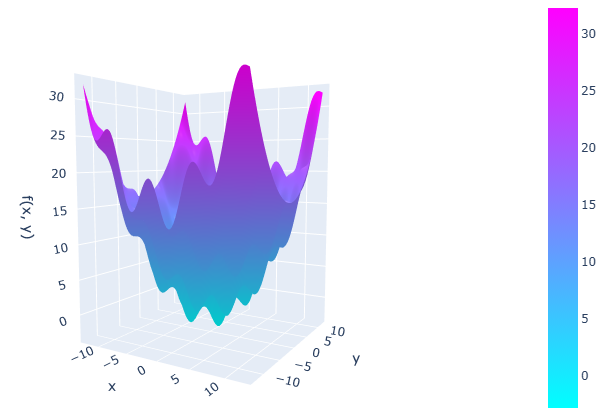

This function is implemented in the following Python code:

In [3]:
# Non-Convex Function:
F = lambda x: (x[0]**2 + x[1]**2) / np.pi**2 - np.pi *np.sin(x[0]) *np.cos(x[1])

The gradient of $f$ is given by
\begin{align*}
\nabla f(x_1, x_2)
&=
\begin{bmatrix}
\frac{\partial}{\partial x_1} \left(\frac{x^2 + y^2}{\pi^2} - \pi \sin(x) \cos(y)\right) \\
\frac{\partial}{\partial x_2} \left(\frac{x^2 + y^2}{\pi^2} - \pi \sin(x) \cos(y)\right)
\end{bmatrix} \\
&=
\begin{bmatrix}
\frac{2x}{\pi^2} - \pi \cos(x) \cos(y) \\
\frac{2y}{\pi^2} + \pi \sin(x) \sin(y)
\end{bmatrix}
\,.
\end{align*}

We model this gradient as a Python function as follows:
<!-- Now we will solve $\nabla f(x, y) = \mathbf{0}$ with $y = 0$ as follows:
\begin{align*}
    \nabla f(x, 0)
    &= \mathbf{0} \\
    \begin{bmatrix}
        \frac{2x}{\pi^2} - \pi \cos(x) \cos(0) \\
        \frac{2 \cdot 0}{\pi^2} + \pi \sin(x) \sin(0)
    \end{bmatrix}
    &=
    \begin{bmatrix}
    0 \\ 0
    \end{bmatrix} \\
    \begin{bmatrix}
        \frac{2x}{\pi^2} - \pi \cos(x) \\
        0
    \end{bmatrix}
    &=
    \begin{bmatrix}
    0 \\ 0
    \end{bmatrix} \\
    \therefore
    \frac{2x}{\pi^2}
    &= \pi \cos(x) \\
    \frac{x}{\cos(x)}
    &= \frac{\pi^3}{2}
\end{align*}

This equations seems that it cannot be solved using explicit formula which means that the equation does not have a closed form solution. Therefore, we will try a numeric solution instead with SciPy. -->

In [4]:
# Gradient of F:
nabla_F = lambda x: np.array(
    [
        (2 *x[0]) / np.pi**2 - np.pi *np.cos(x[0]) *np.cos(x[1]),
        (2 *x[1]) / np.pi**2 + np.pi *np.sin(x[0]) *np.sin(x[1]),
    ]
)

## **3. Optimization Process**

**Gradient Descent**

Gradient descent executes
$$
\mathbf{u}_k \gets \mathbf{u}_{k -1} - \eta \nabla f(\mathbf{u}_{k - 1})
$$
at each $k$-the iteration, where $\eta > 0$ is referred to as the learning rate.

**Adam**

On the other hand, for this problem Adam executes
\begin{align*}
m(\mathbf{u}_{k + 1}) &\gets \beta_1 m(\mathbf{u}_{k}) + (1 - \beta_1) \nabla f(\mathbf{u}_k) \\
v(\mathbf{u}_{k + 1}) &\gets \beta_2 v(\mathbf{u}_{k}) + (1 - \beta_2) \nabla f(\mathbf{u}_k)^2 \\
\hat{m} &\gets \frac{m(\mathbf{u}_{k + 1})}{1 - \beta_1^k} \\
\hat{v} &\gets \frac{v(\mathbf{u}_{k + 1})}{1 - \beta_2^k} \\
\mathbf{u}_{k + 1} &\gets \mathbf{u}_k - \eta \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
\end{align*}
where $\mathrm{image}(m), \mathrm{image}(v), \{\hat{m}, \hat{v}\} \subset \mathbb{R}^3$, $\eta > 0$ is the learning rate and $\epsilon := 10^{-8}$ is a stabilizer, for each $k$-th step.

**Initialisations**

Both DAMSMEL and GD are iterative methods. Therefore, we will make an equal steps for them, namely 1000 steps. We will also use the same starting point for both algorithms as given by
$$
u_0 := (-6, -8) \,.
$$
The hyperparameters for each algorithm are given in the code.

In [5]:
steps = 1000
u0 = np.array([-6, -8])

### **3.1. Optimization with DAMSMEL**

In [6]:
# DirectioNSMEL Optimization
damsmel = DAMSMEL(F, 2)
damsmel_solution = damsmel.optimize(
    u0, 2, M= steps
)
damsmel_monitor = damsmel.monitor.copy()

>>> Runtime: 0.8039941787719727 seconds []


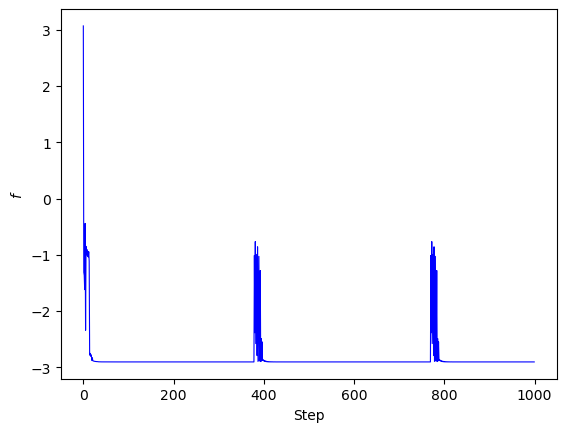

In [7]:
# DirectioNSMEL Result:

display(
    HTML(
        f"<b style='font-size:14px;'>DAMSMEL Solution = {tuple(damsmel_solution)}</b>"
    )
)
damsmel_monitor["loss"].plot(
    xlabel= "Step",
    ylabel= r"$f$",
    color= "blue",
    linewidth= 0.8
);

### **3.2. Optimization with GD**

In [8]:
gd_result = gradient_descent(
    F, nabla_F, u0,
    learning_rate= 0.01,
    M= steps,
    total_time = True,
    verbose= False
    ).copy()

>>> Total Time: 0.013144731521606445 seconds []


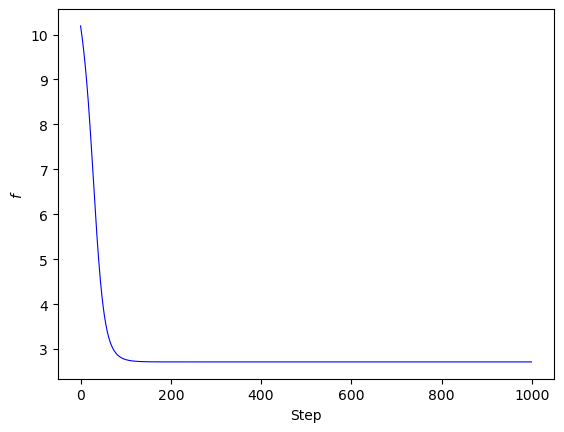

In [9]:
gd_solution = list(gd_result[gd_result["loss"] == gd_result["loss"].min()]["solution"])[0]

display(
    HTML(
        f"<b style='font-size:14px;'>GD Solution = {tuple(gd_solution)}</b>"
    )
)
gd_result["loss"].plot(
    xlabel= "Step",
    ylabel= r"$f$",
    color= "blue",
    linewidth= 0.8
);

### **3.3. Optimisation with Adam**

In [10]:
adam_result = batch_adam(
    F, nabla_F, u0,
    M= steps,
    learning_rate= 0.01
)
adam_solution = list(
    adam_result[
        adam_result["loss"] == adam_result["loss"].min()
    ]["solution"]
)[0]


>>> Runtime: 0.034458160400390625 seconds []


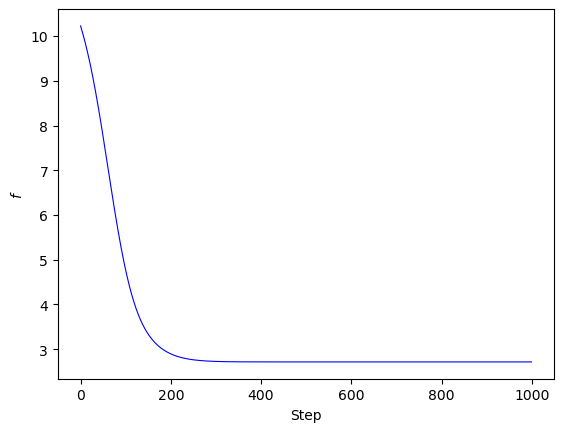

In [11]:
display(
    HTML(
        f"<b style='font-size:14px;'>GD Solution = {tuple(adam_solution)}</b>"
    )
)
adam_result["loss"].plot(
    xlabel= "Step",
    ylabel= r"$f$",
    color= "blue",
    linewidth= 0.8
);

### **3.4. Validation and Evaluation**

Note that the global minimum also lies on local minima. Therefore, first let us evaluate whehter the solution of both optimization methods converges to a local minima. This evaluation can be performed by evaluating the gradient of each solution. If the gradient is zero or very close to zero, then the solution lies on local minima. Let $\mathbf{u}^\ast$ denote the solution by DAMSMEL, $\mathbf{v}^\ast$ denote the solution by GD and $\mathbf{w}^\ast$ be the solution by Adam.

In [12]:
display(
    Markdown(
        r"$\nabla f(\mathbf{u}^\ast) =$" + f" {tuple(nabla_F(damsmel_solution))}"
    ),
    Markdown(
        r"$\nabla f(\mathbf{v}^\ast) =$" + f" {tuple(nabla_F(gd_solution))}"
    ),
    Markdown(
        r"$\nabla f(\mathbf{w}^\ast) =$" + f" {tuple(nabla_F(adam_solution))}"
    )
)

$\nabla f(\mathbf{u}^\ast) =$ (2.254266223689072e-08, 2.9081248529212157e-08)

$\nabla f(\mathbf{v}^\ast) =$ (-1.028360208099599e-08, -1.0292733776395835e-08)

$\nabla f(\mathbf{w}^\ast) =$ (-3.6341152309660174e-09, -3.800343795212768e-08)

The result above shows that DAMSMEL, GD and Adam converges to points in local minima.

We have mentioned the criterion of reaching global minimum earlier by evaluating solutions with respect to the set $S_r$. Now let us designate $r := 0.1$, hence $S_{0.1}$. The evaluation will be conducted by measuring the distance between each solution and $S_{0.1}$ which is given by a map $d:\mathcal{P}([-10, 10]^2) \to [0, 0)$ defined by
$$
\forall A, B \in \mathcal{P}([-10, 10]^2) :\;
d(A, B) := \inf\{ \|a - b\|_2 \in \mathbb{R} \mid a \in A \land b \in B \}
$$
where $\|\cdot\|_2$ denotes the Euclidean norm in $\mathbb{R}^2$. Hence the distances between the soltions and $S_{0.1}$ are presented by $d(\{\mathbf{u}^\ast, S_{0.1})$ for DAMSMEL, $d(\{\mathbf{v}^\ast, S_{0.1})$ for GD, and $d(\{\mathbf{w}^\ast, S_{0.1})$ for Adam. The measurement is computed as follows:

In [13]:
def metric_S(x, r= 0.1):
    if x[0] <= 1.47 - r:
        a = 1.47 - r
    elif x[0] >= 1.47 + r:
        a = 1.47 + r
    else:
        a = x[0]

    if x[1] <= -r:
        b = -r
    elif x[1] >= r:
        b = r
    else:
        b = x[1]
    norm = np.linalg.norm
    return norm(np.array(x) - np.array([a, b]))

display(
    Markdown(
        r"$d(\mathbf{u}, S_{0.1}) =$" + f" {round(metric_S(damsmel_solution), 3)}"
    ),
    Markdown(
        r"$d(\mathbf{v}, S_{0.1}) =$" + f" {round(metric_S(gd_solution), 3)}"
    ),
    Markdown(
        r"$d(\mathbf{w}, S_{0.1}) =$" + f" {round(metric_S(adam_solution), 3)}"
    )
)

$d(\mathbf{u}, S_{0.1}) =$ 0.0

$d(\mathbf{v}, S_{0.1}) =$ 8.161

$d(\mathbf{w}, S_{0.1}) =$ 8.161

The resut shows that DAMSMEL outperforms GD and shows that DAMSMEL has a far accurate result than GD. In addition, both GD and Adam converges to the same local minima.

## **4. Conclusion**

If we observe the monitoring plot of DAMSMEL, it created 3 large spikes, indicating that it attempted to escape the same almost convergent point 3 times and finally reached the global minimum. On the other hand, both GD's and Adam's monitoring plots give a smooth inverse exponential drop, indicating that they never try to escape local minima and eventually are trapped in local minima.

In terms of accuracy, DAMSMEL has a zero distance with the neighbourhood $S_{0.1}$ of the global minimum, indicating a very accurate result. On the other hand, boh GD and Adam have the same distance of 8.161 from the neighbourhood $S_{0.1}$ of the global minimum since they converge to the same point. This result shows that the solutions by both GD and Adam are quite far from the global minimum. This result demonstrates that DAMSMEL outperforms both GD and Adam. In addition, we have also evaluated the gradient of all solutions and they are very close to zero vectors, which shows that DAMSMEL converges to the global minimum while both GD and Adam get trapped in local minima.

This result demonstrates that DAMSMEL's robustness and that it is impressive as it outperforms both GD and Adam.